c:\Users\srayn\EDA-manufacturing\db_utils.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_temp_nulls['Process temperature [K]'] = np.round(process_temp_gradient * process_temp_nulls['Air temperature [K]'] + process_temp_intercept, 1)
c:\Users\srayn\EDA-manufacturing\db_utils.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_temp_nulls['Air temperature [K]'] = np.round(air_temp_gradient * air_temp_nulls['Process temperature [K]'] + air_temp_intercept, 1)
c:\Users\srayn\EDA-manufacturing

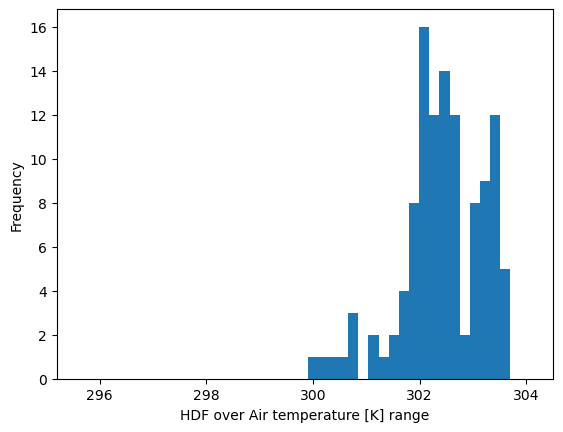

None


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox, yeojohnson
import statsmodels.regression.linear_model as srl
import statsmodels.formula.api as smf

import db_utils as du

In [3]:
dc = du.RDSDatabaseConnector('credentials.yaml')
df = dc.read_rds_table(table='failure_data')
dc.save_data('failure_data', 'failure_data.csv')
df = du.RDSDatabaseConnector.load_data('failure_data.csv')

In [4]:
import plotly.express as px
px.imshow(df.corr(), title="Correlation heatmap of dataframe")

C:\Users\srayn\AppData\Local\Temp\ipykernel_15860\390849661.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  px.imshow(df.corr(), title="Correlation heatmap of dataframe")


In [5]:
df['Rotational speed [rpm]'] = boxcox(df['Rotational speed [rpm]'])[0]

df.rename(columns={'Air temperature [K]': 'Air_temperature_K', 'Process temperature [K]': 'Process_temperature_K', 'Rotational speed [rpm]': 'Rotational_speed_rpm', 'Torque [Nm]': 'Torque_Nm', 'Tool wear [min]': 'Tool_wear_min'}, inplace=True)

model0 = smf.ols('Air_temperature_K ~ Process_temperature_K + Rotational_speed_rpm + Torque_Nm + Tool_wear_min', df).fit()
model1 = smf.ols('Process_temperature_K ~ Air_temperature_K + Rotational_speed_rpm + Torque_Nm + Tool_wear_min', df).fit()
model2 = smf.ols('Rotational_speed_rpm ~ Air_temperature_K + Process_temperature_K + Torque_Nm + Tool_wear_min', df).fit()
model3 = smf.ols('Torque_Nm ~ Air_temperature_K + Process_temperature_K + Rotational_speed_rpm + Tool_wear_min', df).fit()
model4 = smf.ols('Tool_wear_min ~ Air_temperature_K + Process_temperature_K + Rotational_speed_rpm + Torque_Nm', df).fit()
print(model0.rsquared, model1.rsquared, model2.rsquared, model3.rsquared, model4.rsquared)

df.rename(columns={"Air_temperature_K": "Air temperature [K]", "Process_temperature_K": "Process temperature [K]", 'Rotational_speed_rpm': 'Rotational speed [rpm]', 'Torque_Nm': 'Torque [Nm]', 'Tool_wear_min': 'Tool wear [min]'}, inplace=True)


0.7667705360620928 0.7667122777516978 0.8437655348282636 0.8437560783795666 0.0006014073445490542


In [6]:
data = {('Air_temp', 'Max'): [], ('Air_temp', 'Min'): [], ('Process_temp', 'Max'): [], ('Process_temp', 'Min'): [], ('Torque', 'Max'): [], ('Torque', 'Min'): [], ('Tool_wear', 'Max'): [], ('Tool_wear', 'Min'): []}
for column in range(3, 7):
    all_max = df[df.columns[column]].max()
    all_min = df[df.columns[column]].min()
    H_max = df[df['Type'] == 'H'][df.columns[column]].max()
    H_min = df[df['Type'] == 'H'][df.columns[column]].min()
    M_max = df[df['Type'] == 'M'][df.columns[column]].max()
    M_min = df[df['Type'] == 'M'][df.columns[column]].min()
    L_max = df[df['Type'] == 'L'][df.columns[column]].max()
    L_min = df[df['Type'] == 'L'][df.columns[column]].min()
    data[list(data.keys())[2*column - 6]] = [all_max, H_max, M_max, L_max]
    data[list(data.keys())[2*column - 5]] = [all_min, H_min, M_min, L_min]
range_table = pd.DataFrame(data, index=['All', 'H', 'M', 'L'])

In [7]:
display(range_table)

Air_temp        Process_temp           Torque           Tool_wear      
         Max    Min          Max    Min       Max       Min       Max   Min
All    304.5  295.3        313.8  305.7  0.316214  0.316214      76.6   3.8
H      304.2  295.5        313.5  305.9  0.316214  0.316214      72.8  12.8
M      304.4  295.3        313.8  305.7  0.316214  0.316214      76.2   9.7
L      304.5  295.3        313.8  305.7  0.316214  0.316214      76.6   3.8

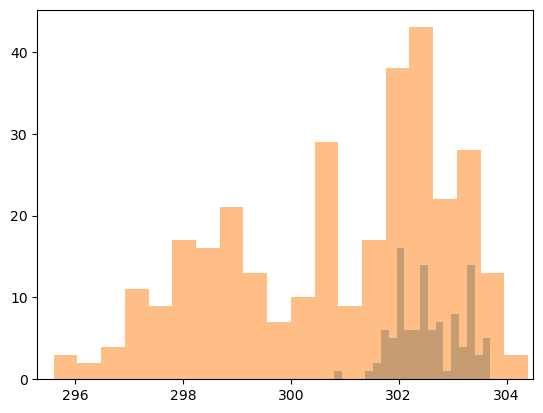

In [10]:
column = 'Air temperature [K]'
x_twf = df[df['TWF'] != 0.0][column]
x_hdf = df[df['HDF'] != 0.0][column]
x_pwf = df[df['PWF'] != 0.0][column]
x_osf = df[df['OSF'] != 0.0][column]
x_rnf = df[df['RNF'] != 0.0][column]
x_total = df[df['Machine failure'] != 0.0][column]
data = [x_hdf, x_total]

for x in data:
    plt.hist(x, bins=20, alpha=0.5)
    plt.xlim([df[column].min(), df[column].max()])

HDF happens for process temp between 310 and 312 and air temp between 300 and 304
HDF happens for torque between 42 and 68
PWF happens for torque between 4 and 18 and between 59 and 76
OSF happens for torque greater than 46
TWF happens for tool wear greater than 195
OSF happens for tool wear greater than 160

Failures happen at tool wear greater than 200
Failures happen at torque greater than 40

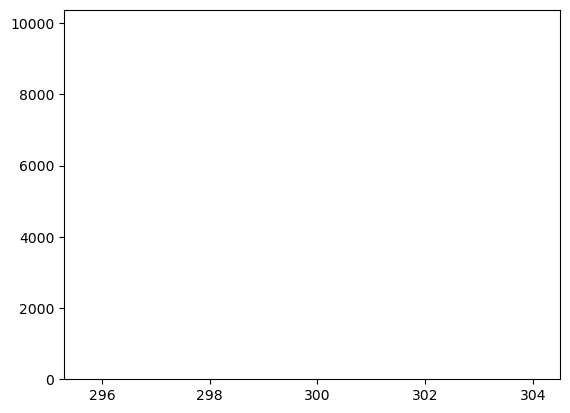

In [9]:
plt.hist(df['HDF'], bins=20)
plt.xlim([df['Air temperature [K]'].min(), df['Air temperature [K]'].max()])
plt.show()

In [9]:
print(df.columns)

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')


In [10]:
H_failures = df[(df['Machine failure'] != 0.0) & (df['Type'] == 'H')]
M_failures = df[(df['Machine failure'] != 0.0) & (df['Type'] == 'M')]
L_failures = df[(df['Machine failure'] != 0.0) & (df['Type'] == 'L')]



In [11]:
TWF_failures = df[df['TWF'] != 0.0]
HDF_failures = df[df['HDF'] != 0.0]
PWF_failures = df[df['PWF'] != 0.0]
OSF_failures = df[df['OSF'] != 0.0]
RNF_failures = df[df['RNF'] != 0.0]

In [14]:
failure_types = [TWF_failures, HDF_failures, PWF_failures, OSF_failures, RNF_failures]
ax4_heights = {'High': [], 'Medium': [], 'Low': []}
for failure_type in failure_types:
    H_failure = len(failure_type[df['Type'] == 'H'])
    M_failure = len(failure_type[df['Type'] == 'M'])
    L_failure = len(failure_type[df['Type'] == 'L'])
    ax4_heights['High'].append(H_failure)
    ax4_heights['Medium'].append(M_failure)
    ax4_heights['Low'].append(L_failure)
ax4_bars = ('TWF', 'HDF', 'PWF', 'OSF', 'RNF')


C:\Users\srayn\AppData\Local\Temp\ipykernel_11756\1673433587.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\srayn\AppData\Local\Temp\ipykernel_11756\1673433587.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\srayn\AppData\Local\Temp\ipykernel_11756\1673433587.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



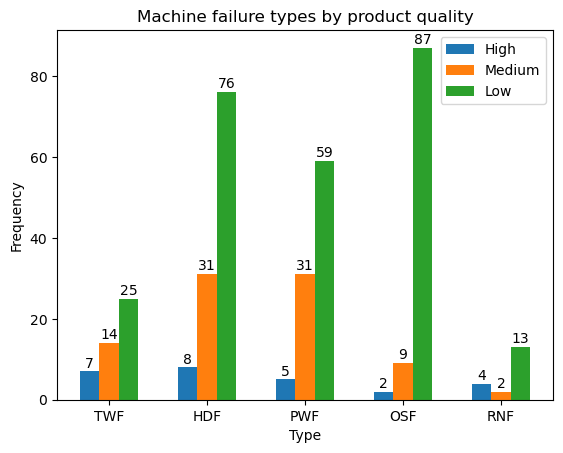

{'High': [7, 8, 5, 2, 4], 'Medium': [14, 31, 31, 9, 2], 'Low': [25, 76, 59, 87, 13]}


In [36]:
x = np.arange(len(ax4_bars))  # the label locations
bar_width = 0.2  # the width of the bars
for index in range(3):
    plt.bar(x + index*bar_width, list(ax4_heights.values())[index], width=bar_width)
    plt.text(0 + index/5, list(ax4_heights.values())[index][0] + 1, s=f'{list(ax4_heights.values())[index][0]}', ha='center')
    plt.text(1 + index/5, list(ax4_heights.values())[index][1] + 1, s=f'{list(ax4_heights.values())[index][1]}', ha='center')
    plt.text(2 + index/5, list(ax4_heights.values())[index][2] + 1, s=f'{list(ax4_heights.values())[index][2]}', ha='center')
    plt.text(3 + index/5, list(ax4_heights.values())[index][3] + 1, s=f'{list(ax4_heights.values())[index][3]}', ha='center')
    plt.text(4 + index/5, list(ax4_heights.values())[index][4] + 1, s=f'{list(ax4_heights.values())[index][4]}', ha='center')
plt.xticks(x + 0.2, ax4_bars)
plt.title('Machine failure types by product quality')
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.legend(list(ax4_heights.keys()))
plt.show()